In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/CNN_assignment.zip"
extract_path = "/content/dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall(extract_path)

In [4]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from glob import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, BatchNormalization, RandomFlip, RandomRotation, RandomZoom, RandomBrightness, RandomContrast

In [5]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


**Load using keras.preprocessing**

Let's load these images off disk using the helpful image_dataset_from_directory utility.

**Create a dataset**

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation', ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


**Visualize the data**

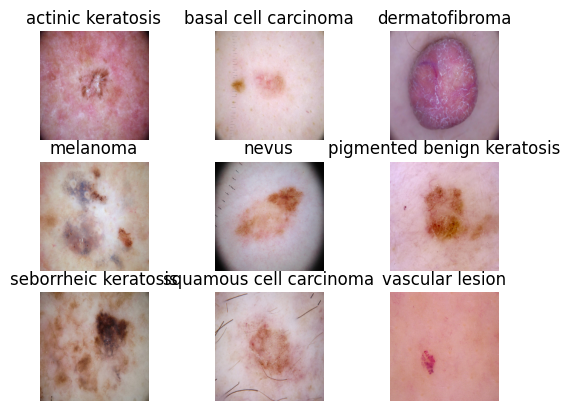

In [ ]:
import matplotlib.pyplot as plt

for i in range(len(class_names)):
    filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], i))
    for image, label in filtered_ds.take(1):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[0]])
        plt.axis('off')

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Create the model**

Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [ ]:
input_shape = (180, 180, 3)
num_classes = 9

model = keras.Sequential([
        Rescaling(1./255, input_shape=input_shape),

        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


**Compile the model**

Choose an appropirate optimiser and loss function for model training

In [ ]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       7,929,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,024,393 (30.61 MB)

 Trainable params: 8,024,393 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

**Train the model**

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 168s 3s/step - accuracy: 0.1894 - loss: 2.3149 - val_accuracy: 0.3423 - val_loss: 1.8294
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 146s 3s/step - accuracy: 0.3316 - loss: 1.8410 - val_accuracy: 0.4295 - val_loss: 1.6271
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.3927 - loss: 1.6853 - val_accuracy: 0.4430 - val_loss: 1.6124
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.4382 - loss: 1.5710 - val_accuracy: 0.4698 - val_loss: 1.5143
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.4930 - loss: 1.4605 - val_accuracy: 0.5145 - val_loss: 1.3904
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 148s 3s/step - accuracy: 0.4995 - loss: 1.4132 - val_accuracy: 0.5257 - val_loss: 1.3677
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 198s 3s/step - accuracy: 0.4899 - loss: 1.4722 - val_accuracy: 0.5324 - val_loss: 1.3233
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.5418 - loss: 1.2901 - val_accuracy: 0.5548 - v

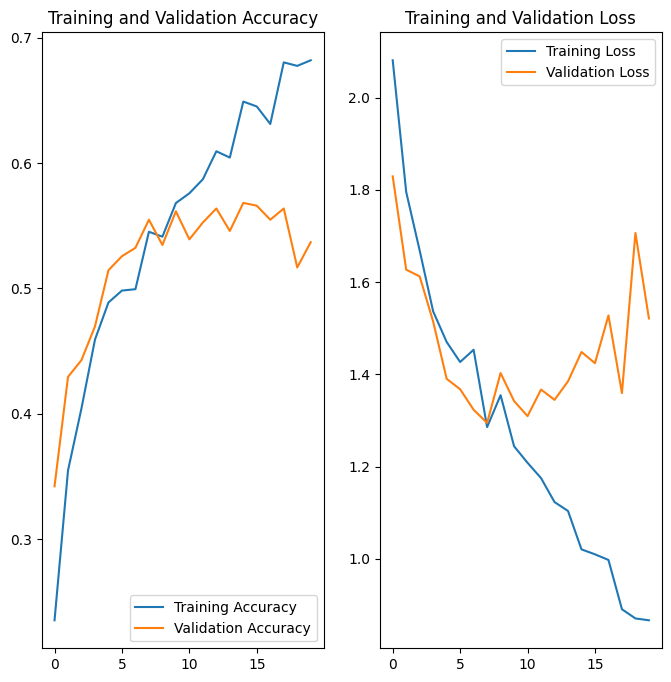

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Findings:**

Model is overfitting (training accuracy much higher than validation accuracy) and struggling with high validation loss.

Augmentation:

In [18]:
data_augmentation = keras.Sequential([
        RandomRotation(0.1),
        RandomZoom(0.2),
        RandomBrightness(0.1),
        RandomContrast(0.1)
    ])

**Create the model, compile and train the model**

**Create Model:**

In [ ]:
input_shape = (180, 180, 3)
num_classes = 9

model = keras.Sequential([
        data_augmentation,
        Rescaling(1./255, input_shape=input_shape),

        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.6),
        layers.Dense(num_classes, activation='softmax')
    ])

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 169s 3s/step - accuracy: 0.1573 - loss: 2.7901 - val_accuracy: 0.2796 - val_loss: 1.9702
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 170s 3s/step - accuracy: 0.2791 - loss: 1.9751 - val_accuracy: 0.2931 - val_loss: 1.9281
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 191s 3s/step - accuracy: 0.3111 - loss: 1.8859 - val_accuracy: 0.4362 - val_loss: 1.6683
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 159s 3s/step - accuracy: 0.4215 - loss: 1.7371 - val_accuracy: 0.3915 - val_loss: 1.7021
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 158s 3s/step - accuracy: 0.4018 - loss: 1.6977 - val_accuracy: 0.3937 - val_loss: 1.6219
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 158s 3s/step - accuracy: 0.4166 - loss: 1.6816 - val_accuracy: 0.5235 - val_loss: 1.4628
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 153s 3s/step - accuracy: 0.4453 - loss: 1.5479 - val_accuracy: 0.5101 - val_loss: 1.4670
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 150s 3s/step - accuracy: 0.4731 - loss: 1.4966 - val_accuracy: 0.5257 - v

**Visualizing the results**

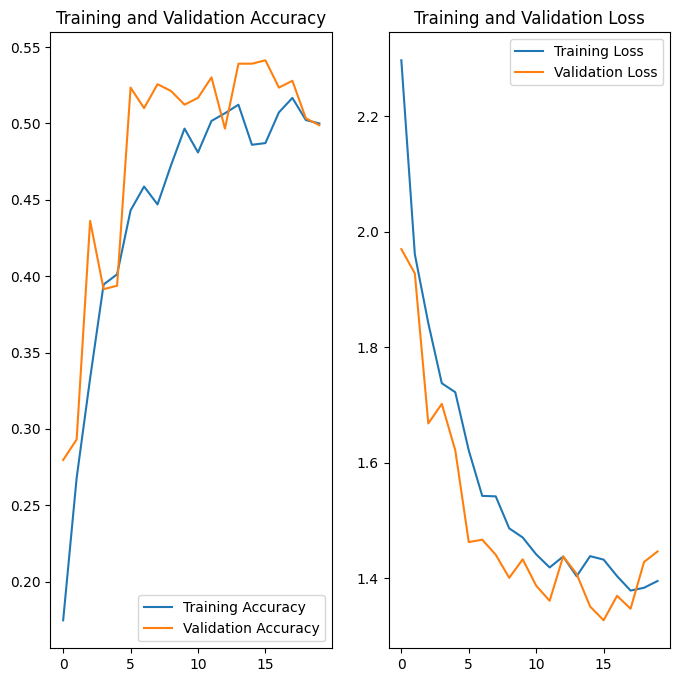

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Findings:**

Overfitting have reduces in new model as compared to previous one.

**Find the distribution of classes in the training dataset.**

In [15]:
# Define a function to count and analyze the distribution of images in each class

def class_distribution_count(directory):
    # Initialize a list to store image counts for each class
    count = []

    # Count the number of images in each class directory
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))]))

    # Get the names of the classes (sub-directories)
    sub_directory = [name for name in os.listdir(directory) if os.path.isdir(os.path.join(directory, name))]

    # Create a DataFrame with class names and corresponding image counts
    df = pd.DataFrame(list(zip(sub_directory, count)), columns=['Class', 'No. of Images'])

    # Sort the DataFrame in ascending order of image counts
    df = df.sort_values(by='No. of Images', ascending=True)

    # Return the sorted DataFrame
    return df

# Call the function to get the class distribution and image count
class_distribution_df = class_distribution_count(data_dir_train)

# Display the DataFrame
class_distribution_df


,Class,No. of Images
8,seborrheic keratosis,77
5,dermatofibroma,95
2,actinic keratosis,114
1,vascular lesion,139
7,squamous cell carcinoma,181
3,nevus,357
6,basal cell carcinoma,376
4,melanoma,438
0,pigmented benign keratosis,462


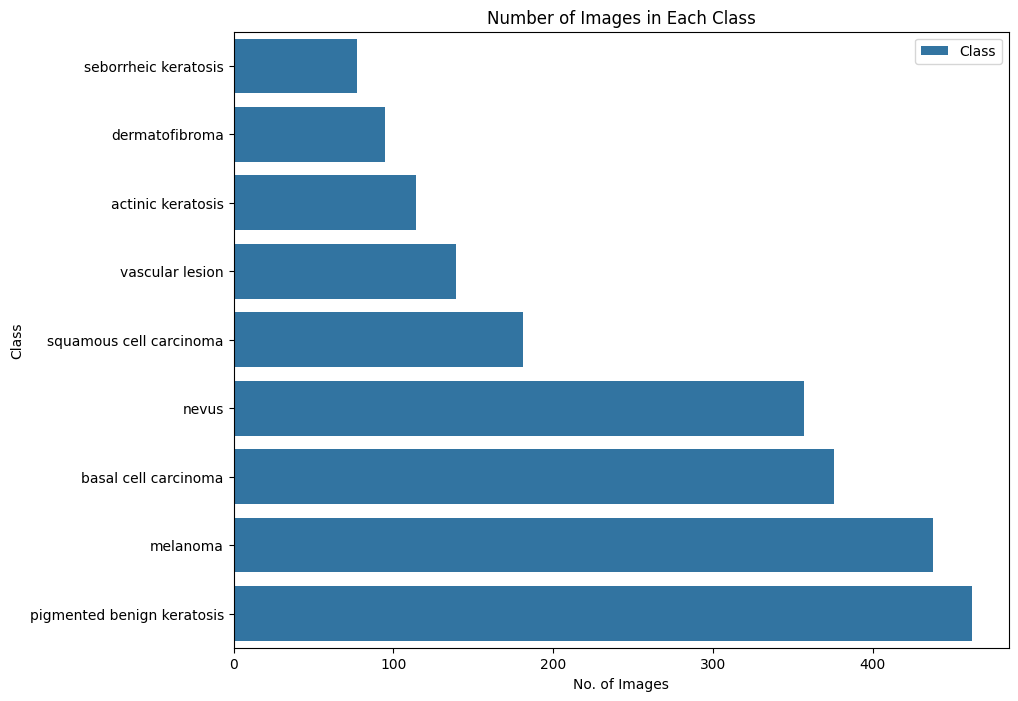

In [16]:
# Visualize the Number of Images in Each Class

# Import the seaborn library for data visualization
import seaborn as sns

# Set the size of the plot figure
plt.figure(figsize=(10, 8))

# Create a bar plot using seaborn
# x-axis: Number of Images
# y-axis: Class names
# Data source: df DataFrame
# Label: "Class"
sns.barplot(x="No. of Images", y="Class", data= class_distribution_df, label="Class")

# Add a title to the plot
plt.title("Number of Images in Each Class")

# Display the plot
plt.show()


**Findings**:

**- Which class has the least number of samples?**

Answer - seborrheic keratosis

**- Which classes dominate the data in terms proportionate number of samples?**

Answer - pigmented benign keratosis

**Rectify the class imbalance**

Context: You can use a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [11]:
!pip install Augmentor

To use Augmentor, the following general procedure is followed:

Instantiate a Pipeline object pointing to a directory containing your initial image data set.
Define a number of operations to perform on this data set using your Pipeline object.
Execute these operations by calling the Pipeline’s sample() method.

In [12]:
path_to_training_dataset='/content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
#path_to_training_dataset=data_dir_train
import Augmentor
for i in class_names:
    #print(i)
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7D1F303A3690>: 100%|██████████| 500/500 [00:18<00:00, 27.68 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7D1F18290890>: 100%|██████████| 500/500 [00:13<00:00, 36.74 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D1F18287F10>: 100%|██████████| 500/500 [00:13<00:00, 37.64 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7D1F21B86850>: 100%|██████████| 500/500 [01:16<00:00,  6.50 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7D1F23760B10>: 100%|██████████| 500/500 [01:13<00:00,  6.83 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7D1F18254B10>: 100%|██████████| 500/500 [00:13<00:00, 37.42 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7D1F21FB7F10>: 100%|██████████| 500/500 [00:32<00:00, 15.46 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D1F183F9310>: 100%|██████████| 500/500 [00:13<00:00, 38.08 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D1F331E3190>: 100%|██████████| 500/500 [00:13<00:00, 36.99 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [13]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

Train the model on the data created using Augmentor

In [14]:
batch_size = 32
img_height = 180
img_width = 180

Create a training dataset

In [15]:
#data_dir_train = pathlib.Path("/content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
#data_dir_test = pathlib.Path("/content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test")
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


Create a validation dataset

In [16]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


Create your model (make sure to include normalization)

In [19]:
input_shape = (180, 180, 3)
num_classes = 9
model = keras.Sequential([
        data_augmentation,
        BatchNormalization(),
        Rescaling(1./255, input_shape=input_shape),

        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        BatchNormalization(),
        layers.Dropout(0.6),
        layers.Dense(num_classes, activation='softmax')
    ])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Compile your model (Choose optimizer and loss function appropriately)

In [20]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Train your model

In [21]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 37s 146ms/step - accuracy: 0.2490 - loss: 2.6828 - val_accuracy: 0.0898 - val_loss: 2.3919
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 24s 140ms/step - accuracy: 0.3703 - loss: 1.8726 - val_accuracy: 0.1403 - val_loss: 2.6728
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 24s 143ms/step - accuracy: 0.4180 - loss: 1.6424 - val_accuracy: 0.1500 - val_loss: 2.3887
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 135ms/step - accuracy: 0.4512 - loss: 1.5195 - val_accuracy: 0.3460 - val_loss: 1.7172
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 142ms/step - accuracy: 0.4615 - loss: 1.4442 - val_accuracy: 0.3890 - val_loss: 1.6235
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 144ms/step - accuracy: 0.5055 - loss: 1.3585 - val_accuracy: 0.4417 - val_loss: 1.4029
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 149ms/step - accuracy: 0.5225 - loss: 1.2931 - val_accuracy: 0.5442 - val_loss: 1.1956
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 24s 140ms/step - accuracy: 0.5378 - loss: 1

Visualize the model results

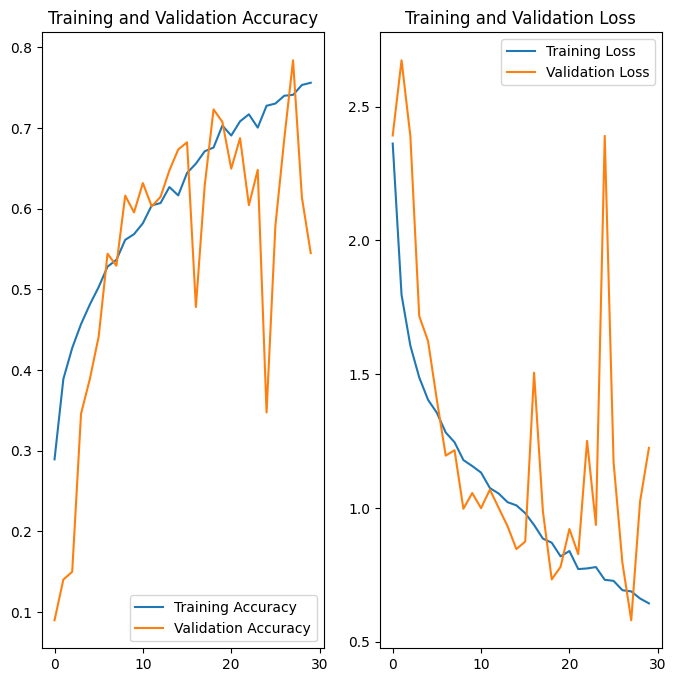

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

**Accuracy of the model have improved and now there is no underfitting/overfitting.**